# xgboost and Tabular data
## update tabular-trees notebook with xgboost and data preperation


See: 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier

This is done with a 15m data set. 

Another approaches are: 
- 1 minute data set (2 std and 0.1% profit)
- more months
- do some descriptive data on MA length and when prices are out of BB range
- extending the dependent variable to more periods, so that the X% rise or fall occurs in the next e.g. 2-5 candles and not in the next candle 

In [1]:
# import data from septembre of 2022 since it was rather stable during this period
import pandas as pd
import numpy as np
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    df = pd.read_csv("/kaggle/input/btcusdt-2023-6-9/btcusdt-2023-6_9.csv", index_col=0).reset_index(drop=True)
else:
    df = pd.read_csv("btc-data/btcusdt-2023-6_9.csv", index_col=0).reset_index(drop=True)


print(df.shape)
df.head(3)

(11716, 6)


,time,open,high,low,close,vol
0,2023.06.01 00:00,27103.1,27108.1,27080.6,27096.9,386.675
1,2023.06.01 00:15,27096.9,27096.9,27036.7,27047.0,408.680
2,2023.06.01 00:30,27047.0,27077.4,27041.0,27054.9,275.080


In [2]:
# transform to date_time
df["time"] = pd.to_datetime(df["time"])

# Extracting day and hour
df["day"] = df["time"].dt.day
df["hour"] = df["time"].dt.hour

# the 10-day moving average
df["10MA"] = df["close"].rolling(window=10).mean()

# Calculate the standard deviation of the closing prices over the same 20-day period
df["10STD"] = df["close"].rolling(window=10).std()

# volume weighted close price
df["vwap"] = df.close/df.vol

# Bollinger Band: 
# simple_moving_average(20) + std x 2 | sma - std x 2
df["bb_upper_band"] = df["10MA"] + 2 * df["10STD"]
df["bb_lower_band"] = df["10MA"] - 2 * df["10STD"]

# daily_open
df["daily_open"] = df.groupby(df["day"])["open"].transform("first")

# daily_close
df["daily_close"] = df.groupby(df["day"])["close"].transform("first")


# Calculate On-Balance Volume (OBV)
df["change"] = df["close"].diff()
df["direction"] = df["change"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
df["obv"] = df["vol"] * df["direction"]
df["obv"] = df["obv"].cumsum()

# define variables that look 1 to three periods into the future
df["open_p1"] = df["open"].shift(1)
df["high_p1"] = df["high"].shift(1)
df["low_p1"] = df["low"].shift(1)
df["close_p1"] = df["close"].shift(1)

df["open_p2"] = df["open"].shift(2)
df["high_p2"] = df["high"].shift(2)
df["low_p2"] = df["low"].shift(2)
df["close_p2"] = df["close"].shift(2)

df["open_p3"] = df["open"].shift(3)
df["high_p3"] = df["high"].shift(3)
df["low_p3"] = df["low"].shift(3)
df["close_p3"] = df["close"].shift(3)


print(df.shape)
df[18:].head(3) # data set starts with the 20th observation since the first 20 rows had to be used for the moving average

(11716, 30)


,time,open,high,low,close,vol,day,hour,10MA,10STD,...,low_p1,close_p1,open_p2,high_p2,low_p2,close_p2,open_p3,high_p3,low_p3,close_p3
18,2023-06-01 04:30:00,27131.7,27152.2,27103.3,27103.4,657.897,1,4,27172.38,82.346447,...,27089.4,27131.7,27060.2,27135.0,27050.0,27115.9,27103.6,27103.6,27012.0,27060.2
19,2023-06-01 04:45:00,27103.4,27144.9,27064.5,27069.3,960.815,1,4,27160.82,88.292969,...,27103.3,27103.4,27115.9,27133.0,27089.4,27131.7,27060.2,27135.0,27050.0,27115.9
20,2023-06-01 05:00:00,27069.3,27078.8,27036.7,27044.4,451.196,1,5,27140.56,89.556180,...,27064.5,27069.3,27131.7,27152.2,27103.3,27103.4,27115.9,27133.0,27089.4,27131.7


In [29]:
df.tail(10)

,time,open,high,low,close,vol,day,hour,10MA,10STD,...,close_p1,open_p2,high_p2,low_p2,close_p2,open_p3,high_p3,low_p3,close_p3,y_bb
11706,2023-09-30 21:45:00,26984.3,26993.8,26978.2,26993.7,184.867,30,21,27001.96,13.610633,...,26984.3,27008.9,27009.0,26990.0,26999.9,27008.6,27009.0,26992.0,27008.9,False
11707,2023-09-30 22:00:00,26993.7,26997.0,26974.3,26983.0,178.602,30,22,26998.86,14.085706,...,26993.7,26999.9,27004.7,26984.0,26984.3,27008.9,27009.0,26990.0,26999.9,False
11708,2023-09-30 22:15:00,26983.0,26990.3,26981.3,26984.5,116.360,30,22,26996.23,14.063906,...,26983.0,26984.3,26993.8,26978.2,26993.7,26999.9,27004.7,26984.0,26984.3,False
11709,2023-09-30 22:30:00,26984.5,27026.0,26984.5,27025.1,266.921,30,22,27001.13,14.788513,...,26984.5,26993.7,26997.0,26974.3,26983.0,26984.3,26993.8,26978.2,26993.7,False
11710,2023-09-30 22:45:00,27025.1,27025.2,27009.7,27011.5,204.762,30,22,27001.86,15.133054,...,27025.1,26983.0,26990.3,26981.3,26984.5,26993.7,26997.0,26974.3,26983.0,False
11711,2023-09-30 23:00:00,27011.5,27038.0,27011.5,27026.8,322.886,30,23,27002.63,16.261546,...,27011.5,26984.5,27026.0,26984.5,27025.1,26983.0,26990.3,26981.3,26984.5,False
11712,2023-09-30 23:15:00,27026.8,27044.3,27014.6,27016.8,219.551,30,23,27003.45,16.794063,...,27026.8,27025.1,27025.2,27009.7,27011.5,26984.5,27026.0,26984.5,27025.1,False
11713,2023-09-30 23:30:00,27016.8,27058.2,27016.8,27057.3,198.178,30,23,27008.29,23.977371,...,27016.8,27011.5,27038.0,27011.5,27026.8,27025.1,27025.2,27009.7,27011.5,False
11714,2023-09-30 23:45:00,27057.3,27061.2,27046.8,27054.4,182.027,30,23,27013.74,27.754767,...,27057.3,27026.8,27044.3,27014.6,27016.8,27011.5,27038.0,27011.5,27026.8,False
11715,2023-10-01 00:00:00,27054.4,27066.7,27054.3,27066.6,226.847,1,0,27021.97,30.153461,...,27054.4,27016.8,27058.2,27016.8,27057.3,27026.8,27044.3,27014.6,27016.8,False


In [28]:
df.head(5).close.mean()

27241.8

In [25]:
df.head(10)

,time,open,high,low,close,vol,day,hour,10MA,10STD,...,close_p1,open_p2,high_p2,low_p2,close_p2,open_p3,high_p3,low_p3,close_p3,y_bb
9,2023-06-01 02:15:00,27156.9,27185.0,27145.5,27184.9,318.473,1,2,27117.44,47.868273,...,27156.9,27137.2,27180.0,27133.9,27170.2,27142.4,27158.3,27120.0,27137.2,False
10,2023-06-01 02:30:00,27184.9,27296.8,27169.2,27247.0,2235.607,1,2,27132.45,62.122858,...,27184.9,27170.2,27181.0,27147.2,27156.9,27137.2,27180.0,27133.9,27170.2,True
11,2023-06-01 02:45:00,27247.0,27264.3,27181.5,27199.0,875.719,1,2,27147.65,57.300422,...,27247.0,27156.9,27185.0,27145.5,27184.9,27170.2,27181.0,27147.2,27156.9,True
12,2023-06-01 03:00:00,27199.0,27343.4,27179.3,27304.1,2538.299,1,3,27172.57,66.008435,...,27199.0,27184.9,27296.8,27169.2,27247.0,27156.9,27185.0,27145.5,27184.9,True
13,2023-06-01 03:15:00,27304.1,27325.0,27274.0,27274.0,895.629,1,3,27191.57,65.019160,...,27304.1,27247.0,27264.3,27181.5,27199.0,27184.9,27296.8,27169.2,27247.0,True
14,2023-06-01 03:30:00,27274.0,27290.3,27055.4,27103.6,3447.623,1,3,27191.93,64.463410,...,27274.0,27199.0,27343.4,27179.3,27304.1,27247.0,27264.3,27181.5,27199.0,True
15,2023-06-01 03:45:00,27103.6,27103.6,27012.0,27060.2,1554.285,1,3,27183.71,75.736142,...,27103.6,27304.1,27325.0,27274.0,27274.0,27199.0,27343.4,27179.3,27304.1,True
16,2023-06-01 04:00:00,27060.2,27135.0,27050.0,27115.9,919.264,1,4,27181.58,77.469217,...,27060.2,27274.0,27290.3,27055.4,27103.6,27304.1,27325.0,27274.0,27274.0,False
17,2023-06-01 04:15:00,27115.9,27133.0,27089.4,27131.7,591.857,1,4,27177.73,79.038388,...,27115.9,27103.6,27103.6,27012.0,27060.2,27274.0,27290.3,27055.4,27103.6,False
18,2023-06-01 04:30:00,27131.7,27152.2,27103.3,27103.4,657.897,1,4,27172.38,82.346447,...,27131.7,27060.2,27135.0,27050.0,27115.9,27103.6,27103.6,27012.0,27060.2,False


In [24]:
df.head(10).close.mean()

27172.380000000005

## dependent variable

In [3]:

# GOAL:
# if the price is outside of the bollinger bands: 
#    is the next candle 0.5% away from the bb value?

# Create a new column "y_bb" initialized with False
df["y_bb"] = False

# Check conditions and set values accordingly
df.loc[(df["low"] < df["bb_lower_band"]) & (df["high_p1"] > df["bb_lower_band"]*1.002), "y_bb"] = True
df.loc[(df["high"] > df["bb_upper_band"]) & (df["low_p1"] < df["bb_upper_band"]/1.002), "y_bb"] = True

In [4]:
df.y_bb.sum()

2041

# XGBoost

In [5]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'vol', 'day', 'hour', '10MA',
       '10STD', 'vwap', 'bb_upper_band', 'bb_lower_band', 'daily_open',
       'daily_close', 'change', 'direction', 'obv', 'open_p1', 'high_p1',
       'low_p1', 'close_p1', 'open_p2', 'high_p2', 'low_p2', 'close_p2',
       'open_p3', 'high_p3', 'low_p3', 'close_p3', 'y_bb'],
      dtype='object')

In [6]:
from sklearn.model_selection import train_test_split

cols = ['open', 'high', 'low', 'close', 'vol', 'day', 'hour', '10MA', 
       '10STD', 'vwap', 'bb_upper_band', 'bb_lower_band', 'daily_open', 
       'daily_close', 'change', 'direction', 'obv']

df = df.dropna()
X,y = df[cols],df["y_bb"]

# do the train test splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=None,shuffle=False) #do the split on variable y to avoid zero y entries

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

xg = GradientBoostingClassifier() # min_samples_leaf=4
xg.fit(X_train, y_train)

GradientBoostingClassifier()

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_test = xg.predict(X_test)
accuracy_score(y_test, y_pred_test)

0.8916979842842501

In [9]:
conf_m = confusion_matrix(y_test, y_pred_test)
conf_m

array([[2354,   78],
       [ 239,  256]])

<Axes: >

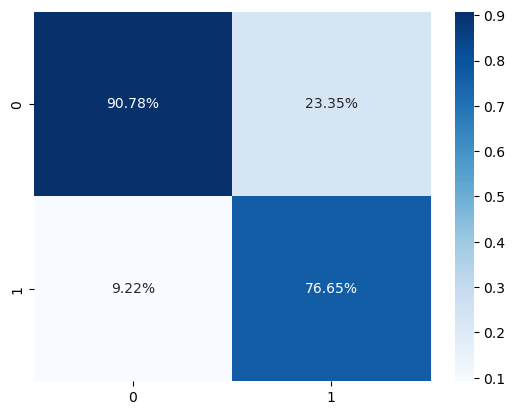

In [10]:
import seaborn as sns
sns.heatmap(conf_m/np.sum(conf_m,axis=0), annot=True, fmt='.2%', cmap='Blues')

In [11]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.91      0.97      0.94      2432
        True       0.77      0.52      0.62       495

    accuracy                           0.89      2927
   macro avg       0.84      0.74      0.78      2927
weighted avg       0.88      0.89      0.88      2927



Overall, it seems like a useful model. However it is spurious that the precision is at exactly 75%. 

More ways to improve the model would be to 
- get more data
- add other symbols, like ETH, EUR/USD pair, S&P 500, etc.

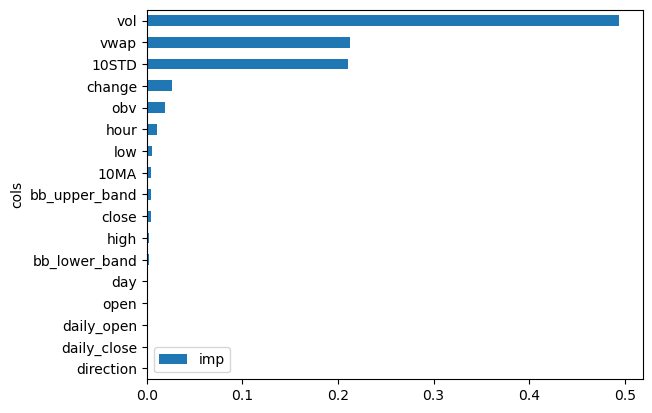

In [12]:
pd.DataFrame(dict(cols=X_train.columns, imp=xg.feature_importances_)).sort_values(by=['imp']).plot('cols', 'imp', 'barh');

In [13]:
import pickle

# Save the model to a file
with open('../bb-bot/src/xgboost_model.pkl', 'wb') as file:
    pickle.dump(xg, file)


In [14]:

# Load the model from the file
with open('xgboost_model.pkl', 'rb') as file:
    model = pickle.load(file)


In [15]:
pred = model.predict(X_test.head(1))
pred

array([False])

In [16]:
X_test.head(20)

,open,high,low,close,vol,day,hour,10MA,10STD,vwap,bb_upper_band,bb_lower_band,daily_open,daily_close,change,direction,obv
8789,27200.4,27206.0,27182.3,27182.4,365.033,31,12,27216.70,20.437601,74.465596,27257.575203,27175.824797,29258.1,29201.9,-18.0,-1,-238703.204
8790,27182.4,27198.6,27179.7,27190.7,248.038,31,13,27212.57,21.162338,109.623122,27254.894676,27170.245324,29258.1,29201.9,8.3,1,-238455.166
8791,27190.7,27197.0,27188.6,27192.4,110.165,31,13,27207.35,18.675667,246.833386,27244.701335,27169.998665,29258.1,29201.9,1.7,1,-238345.001
8792,27192.4,27210.6,27192.3,27198.6,264.978,31,13,27203.72,16.072115,102.644748,27235.864230,27171.575770,29258.1,29201.9,6.2,1,-238080.023
8793,27198.6,27201.6,27184.0,27184.3,275.642,31,13,27199.55,15.024665,98.621763,27229.599330,27169.500670,29258.1,29201.9,-14.3,-1,-238355.665
8794,27184.3,27237.0,27184.3,27224.9,576.704,31,14,27199.77,15.412408,47.207753,27230.594817,27168.945183,29258.1,29201.9,40.6,1,-237778.961
8795,27224.9,27323.9,27213.9,27285.2,2800.954,31,14,27205.76,30.596993,9.741395,27266.953987,27144.566013,29258.1,29201.9,60.3,1,-234978.007
8796,27285.2,27627.5,27261.5,27454.3,9560.463,31,14,27230.32,84.430863,2.871650,27399.181726,27061.458274,29258.1,29201.9,169.1,1,-225417.544
8797,27454.3,27493.0,27282.9,27291.1,5917.776,31,14,27240.43,85.116600,4.611716,27410.663201,27070.196799,29258.1,29201.9,-163.2,-1,-231335.320
8798,27291.1,27304.5,27014.4,27249.8,9365.094,31,15,27245.37,83.960891,2.909720,27413.291782,27077.448218,29258.1,29201.9,-41.3,-1,-240700.414


# use live data

In [17]:
import requests
import time
import pandas as pd

# Define the endpoint and parameters
base_url = "https://api-testnet.bybit.com"
endpoint = "/v5/market/kline"
symbol = "BTCUSD"  # Example trading pair
interval = "1"    # Kline interval, e.g., "1", "5", "15", "60", "240", etc.
limit = 4        # Number of klines to fetch
start_time = int(time.time()) - 3600 * 24  # Start time in seconds (e.g., 24 hours ago)

# Construct the URL
url = f"{base_url}{endpoint}?category=linear&symbol={symbol}&interval={interval}&limit={limit}"#&start_time={start_time}"

# Make the GET request
response = requests.get(url,headers={}, data={})
data = response.json() 

print(data)
print(pd.Timestamp(data["time"],unit="ms"))
print(data["result"]["list"])



{'retCode': 0, 'retMsg': 'OK', 'result': {'symbol': 'BTCUSD', 'category': 'linear', 'list': [['1716493200000', '67577.5', '67577.5', '67561', '67562.5', '274102', '4.05703235'], ['1716493140000', '67560', '67577.5', '67551.5', '67577.5', '723352', '10.70715993'], ['1716493080000', '67509', '67569.5', '67509', '67560', '1323025', '19.58892327'], ['1716493020000', '67570', '67570.5', '67504.5', '67509', '636850', '9.4290513']]}, 'retExtInfo': {}, 'time': 1716493225393}
2024-05-23 19:40:25.393000
[['1716493200000', '67577.5', '67577.5', '67561', '67562.5', '274102', '4.05703235'], ['1716493140000', '67560', '67577.5', '67551.5', '67577.5', '723352', '10.70715993'], ['1716493080000', '67509', '67569.5', '67509', '67560', '1323025', '19.58892327'], ['1716493020000', '67570', '67570.5', '67504.5', '67509', '636850', '9.4290513']]
